# Global Meridional Overturning (MOC)

This notebook plots the global MOC in depth and isopycnal (`rho2`) space as well as a break down of the Indo-Pacific and Atlantic basin.

In [1]:
import os
import datetime
import itertools
import cmip_basins
import cftime

In [2]:
from gfdlnb.tools import VerticalSplitScale

In [3]:
config = {
    "startyr": "11",
    "endyr": "30",
    "dora_id": "esm45-1",
    "pathPP": None,
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [4]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [5]:
import doralite
import glob
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [7]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

# 1. List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

#pathPP = experiment["pathPP"]
#expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

print(start,end)

11 30


### Determine What Files to Load

In [8]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [9]:
dset = "av"

In [10]:
datafiles = []
staticfiles = []

for experiment in experiments:

    _pathPP = experiment["pathPP"]

    ddict = {component: {} for component in ["ocean_annual_z", "ocean_annual_rho2"]}
    ddict["ocean_annual_z"]["variables"] = ["vmo"]
    ddict["ocean_annual_rho2"]["variables"] = ["vmo", "volcello"]

    for component in ddict:
        # print(component)

        if dset == "ts":
            chunks = os.listdir(
                os.path.join(_pathPP, component, dset, component.split("_")[1])
            )  # ts
        else:
            chunks = os.listdir(os.path.join(_pathPP, component, dset))  # av
        if len(chunks) > 1:
            print(
                "Warning: More than one chunk size available. Using %s"
                % sorted(chunks)[-1]
            )
        chunk = sorted(chunks)[-1]

        filelist = []

        if dset == "ts":
            for varname in ddict[component]["variables"]:
                # print(varname)
                files = sorted(
                    glob.glob(
                        f"{_pathPP}{component}/{dset}/{component.split('_')[1]}/{chunk}/{component}.*.{varname}.nc",
                        recursive=True,
                    )
                )  # ts
        else:
            files = sorted(
                glob.glob(
                    f"{_pathPP}{component}/{dset}/{chunk}/{component}.*.nc",
                    recursive=True,
                )
            )  # av

            files_in_range = [x for x in files if is_in_range(x, start, end)]
            filelist = filelist + files_in_range
        ddict[component]["filelist"] = filelist

    filelist = []
    for component in ddict:
        filelist = filelist + ddict[component]["filelist"]

    _static = f"{component}/{component}.static.nc"
    _staticfile = f"{_pathPP}{_static}"

    staticfiles.append(_staticfile)
    datafiles.append(filelist)

In [11]:
allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.0011-0015.ann.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.0016-0020.ann.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.0021-0025.ann.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.0026-0030.ann.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_rho2/ocean_annual_rho2.static.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b04_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0011-0015.ann.nc
/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b0

### DMgetting Files

Dora cannot issue calls to dmget

In [12]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [13]:
def infer_date_range(ds, ref_time="1970-01-01T00:00:00Z"):
    """Returns a tuple of start year and end year from xarray dataset

    Parameters
    ----------
    ds : xarray.Dataset
        Input dataset

    Returns
    -------
    tuple
        (start year, end year) for time dimension of the dataset
    """

    if "time_bnds" in list(ds.variables):

        # Xarray decodes bounds times relative to the epoch and
        # returns a numpy timedelta object in some instances
        # instead of a cftime datetime object. Manual decoding
        # and shifting may be necessary

        if isinstance(ds["time_bnds"].values[0][0], np.timedelta64):

            # When opening multi-file datasets with open_mfdataset(),
            # xarray strips out the calendar encoding. Since bounds
            # are computed differently to begin with, fall back to
            # another FMS generated time variable to get the calendar
            # base date.

            if "units" in ds["time"].encoding.keys():
                base_time = ds["time"].encoding["units"]
            elif "units" in ds["average_T1"].encoding.keys():
                base_time = ds["average_T1"].encoding["units"]
            else:
                base_time = None

            if base_time is not None:
                base_time = base_time.split(" ")[2:4]
                base_time = np.datetime64(f"{base_time[0]}T{base_time[1]}Z")
                offset = base_time - np.datetime64(ref_time)

                t0 = ds["time_bnds"].values[0][0] + offset
                t0 = datetime.fromtimestamp(int(np.ceil(int(t0) * 1.0e-9)))
                t0 = tuple(t0.timetuple())
                # if start bound is Dec-31, advance to next year
                t0 = (t0[0] + 1) if (t0[1:3] == (12, 31)) else t0[0]

                t1 = ds["time_bnds"].values[-1][-1] + offset
                t1 = datetime.fromtimestamp(int(np.ceil(int(t1) * 1.0e-9)))
                t1 = tuple(t1.timetuple())
                # if end bound is Jan-1, fall back to previous year
                t1 = (t1[0] - 1) if (t1[1:3] == (1, 1)) else t1[0]

            else:
                # return very obvious incorrect dates to alert the
                # user that the inferred time range failed
                t0 = 9999
                t1 = 9999

        else:
            t0 = tuple(ds["time_bnds"].values[0][0].timetuple())[0]

            # if end bound is Jan-1, fall back to previous year
            t1 = tuple(ds["time_bnds"].values[-1][-1].timetuple())
            t1 = (t1[0] - 1) if (t1[1:3] == (1, 1)) else t1[0]

    else:
        t0 = int(ds["time"].isel({"time": 0}).dt.strftime("%Y"))
        t1 = int(ds["time"].isel({"time": -1}).dt.strftime("%Y"))

    return (t0, t1)

In [14]:
dsets = []

for n,filelist in enumerate(datafiles):
    filelist = [x for x in filelist if "ocean_annual_z" in x]
   
    ds = xr.open_mfdataset(filelist, use_cftime=True)
    dss = xr.open_dataset(staticfiles[n])

    dsnew = xr.Dataset()
    dsnew["vmo"] = ds.vmo
    dsnew["z_i"] = ds.z_i
    dsnew["deptho"] = xr.DataArray(dss["deptho"].values,dims=("yh","xh"))
    dsnew["geolon_v"] = xr.DataArray(dss["geolon_v"].values,dims=("yq","xh"))
    dsnew["geolat_v"] = xr.DataArray(dss["geolat_v"].values,dims=("yq","xh"))

    if (len(dsnew.yq) == 1081) | (len(dsnew.yq) == 1162):
        dsnew = dsnew.isel({"yq":slice(1,None)})

    dsnew = dsnew.mean("time").load()

    dsnew.attrs["date_range"] = f"Years {str('-').join([str(x) for x in infer_date_range(ds)])}"
    
    dsets.append(dsnew)  

### Overturning in depth space (`ocean_annual_z`)

In [15]:
rho0 = 1035.

def calc_moc_z(vmo):
    # Sum over the zonal direction and integrate from bottom
    # Reverse vertical (density) axis and integrate
    integ_layers = vmo.sum("xh").reindex(z_l=vmo.z_l[::-1]).cumsum("z_l")
    # The result of the integration over layers is evaluated at the interfaces
    # with psi = 0 as the bottom boundary condition for the integration
    bottom_condition = xr.zeros_like(integ_layers.isel({"z_l": 0}))
    # combine bottom condition with data array
    psi_raw = xr.concat(
        [integ_layers.reindex(z_l=integ_layers.z_l[::-1]), bottom_condition], dim="z_l"
    )
    # need to rechunk to new size
    psi_raw = psi_raw.chunk({'z_l': len(psi_raw['z_l'])})
    # rename to correct dimension and add correct vertical coordinate
    psi = -psi_raw.rename({'z_l': 'z_i'}).transpose('z_i','yq')
    psi['z_i'] = ds.z_i
    psi.name = 'psi'
    # Convert kg.s-1 to Sv (1e6 m3.s-1)
    moc_z = psi / rho0 / 1.0e6
    #moc_z = moc_z.mean('time').load()
    return moc_z

In [16]:
def plot_panel(ax, y, z, psi, depth, domain):
    if domain == "atlarc":
        levels = np.arange(-28, 30, 2)
    elif domain == "global":
        levels = np.arange(-40, 42, 2)

    cb = ax.contourf(y, z, psi, levels=levels, cmap="RdBu_r")

    # Setting y-axis limits to avoid singular transformation warning for future calls
    ax.set_ylim([np.min(z) - 500, np.max(z) + 500])

    cs = ax.contour(y, z, psi, levels=levels, colors="k", linewidths=0.3)
    zero_contours = ax.contour(y, z, psi, levels=[0], colors="blue", linewidths=0)

    ax.set_yscale("splitscale", zval=[6500.0, 2000.0, 0.0])
    plt.axhline(y=2000, color="k", linestyle="dashed", linewidth=0.8)

    _ = ax.fill_between(y, depth, 6750, color="gray", zorder=2)

    plt.colorbar(cb)

    if domain == "atlarc":
        Y, Z = np.meshgrid(y, z)
        mask = (Y >= 20) & (Y <= 80) & (Z >= 500) & (Z <= 2000)
        _psi = psi.values
        max_psi = np.max(_psi[mask])
        max_index = np.unravel_index(np.argmax(_psi[mask]), _psi[mask].shape)
        max_y = Y[mask][max_index]
        max_z = Z[mask][max_index]

        square_size = 10
        ax.plot(
            max_y,
            max_z,
            marker="s",
            color="yellow",
            markersize=square_size + 5,
            markeredgewidth=2,
            markeredgecolor="yellow",
            markerfacecolor="none",
        )
        ax.annotate(
            f"{max_psi:.1f} Sv",
            xy=(max_y, max_z),
            xytext=(10, 10),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="black"),
            bbox=dict(
                facecolor="white",
                edgecolor="black",
                boxstyle="round,pad=0.2",
                linewidth=0.5,
                alpha=0.7,
            ),
        )

        z_values = []
        for path in zero_contours.get_paths():  # Use get_paths() instead of allsegs
            vertices = path.vertices
            x = vertices[:, 0]
            z_val = vertices[:, 1]
            mask = (20 <= x) & (x <= 55) & (2500 <= z_val) & (z_val <= 4000)
            z_values.extend(z_val[mask])

        mean_z = np.mean(z_values) if z_values else None

        if mean_z:
            ax.annotate(
                f"Mean Depth:\n{mean_z:.0f} m",
                xy=(40, mean_z),
                xytext=(-10, -30),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->", color="black"),
                bbox=dict(
                    facecolor="white",
                    edgecolor="black",
                    boxstyle="round,pad=0.2",
                    linewidth=0.5,
                    alpha=0.7,
                ),
            )

In [17]:
def prepare_data_z(ds,domain="global"):

    # Transpose the depth from the t-grid to the v-grid (just for plotting)
    ds["deptho"] = xr.DataArray(ds.deptho.values,dims=("yq","xh"))

    if domain == "atlarc":
        # Calculate the basin mask on the v-grid
        basin = cmip_basins.generate_basin_codes(ds,lon="geolon_v", lat="geolat_v")
        mask = xr.where((basin == 2) | (basin == 4) | (basin == 6) | (basin == 7) | (basin == 8) | (basin ==9) , 1., np.nan)
    elif domain == "global":
        mask = 1.
    else:
        raise ValueError(f"Invalid domain {domain}")

    y = (ds.geolat_v * mask).mean("xh")
    y = xr.DataArray(y.values, dims=("y"), coords={"y":y.values})
    
    yloc = xr.where(y.isnull(), False, True)
    
    z = ds.z_i
    
    psi = calc_moc_z(ds.vmo*mask)
    psi = xr.DataArray(psi.values,dims=("z","y"), coords={"z":z.values, "y":y.values})
    psi = psi[:,yloc]
    
    depth = xr.DataArray((ds.deptho*mask).max("xh").values, dims=("y"), coords={"y":y.values})
    depth = depth[yloc]
    y = y[yloc]

    return (y, z, psi, depth, domain)

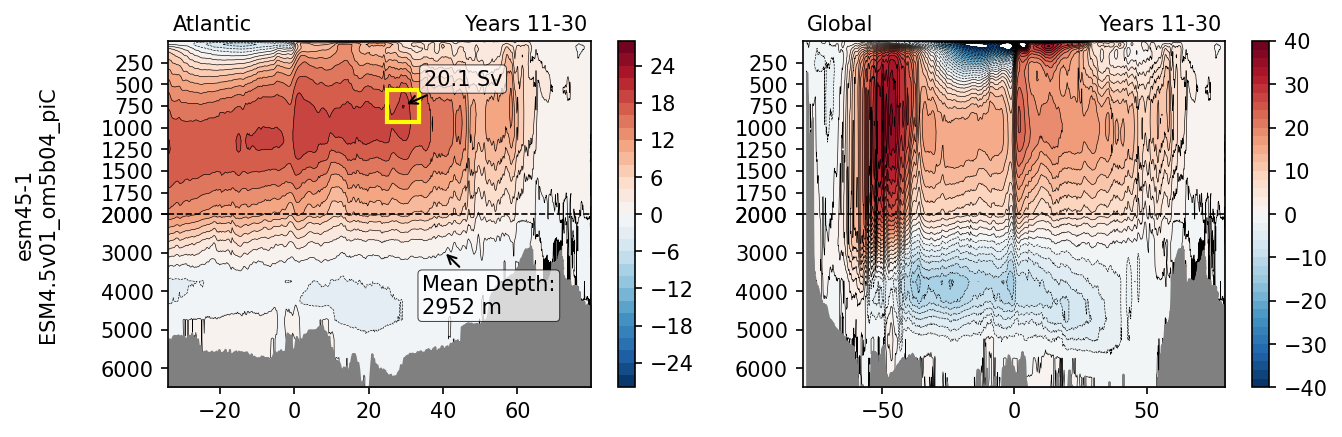

In [18]:
nexp = len(dsets)

fig = plt.figure(figsize=(10,3*nexp), dpi=150)

plotcounter = 1
for n,ds in enumerate(dsets):

    ax = plt.subplot(nexp,2,plotcounter)
    plot_panel(ax, *prepare_data_z(ds, domain="atlarc"))
    if "date_range" in ds.attrs.keys():
        date_range = ds.attrs["date_range"]
    else:
        date_range = ""
    ax.text(.99,1.03,date_range,ha="right", transform=ax.transAxes)
    ax.text(.01,1.03,f"Atlantic",ha="left", transform=ax.transAxes)
    plotcounter += 1

    ax.set_ylabel(config["dora_id"].split(",")[n]+"\n"+experiments[n]["expName"], labelpad=20)

    ax = plt.subplot(nexp,2,plotcounter)
    plot_panel(ax, *prepare_data_z(ds, domain="global"))
    ax.text(.99,1.03,date_range,ha="right", transform=ax.transAxes)
    ax.text(.01,1.03,f"Global",ha="left", transform=ax.transAxes)
    plotcounter += 1

### Overturning in density space (`ocean_annual_rho2`)

In [19]:
dsets = []

for n,filelist in enumerate(datafiles):
    filelist = [x for x in filelist if "ocean_annual_rho2" in x]
    
    ds = xr.open_mfdataset(filelist, use_cftime=True)
    dss = xr.open_dataset(staticfiles[n])

    dsnew = xr.Dataset()
    dsnew["vmo"] = ds.vmo
    dsnew["rho2_i"] = ds.rho2_i
    dsnew["deptho"] = xr.DataArray(dss["deptho"].values,dims=("yh","xh"))
    dsnew["geolon_v"] = xr.DataArray(dss["geolon_v"].values,dims=("yq","xh"))
    dsnew["geolat_v"] = xr.DataArray(dss["geolat_v"].values,dims=("yq","xh"))

    if (len(dsnew.yq) == 1081) | (len(dsnew.yq) == 1162):
        dsnew = dsnew.isel({"yq":slice(1,None)})

    dsnew = dsnew.mean("time").load()

    dsnew.attrs["date_range"] = f"Years {str('-').join([str(x) for x in infer_date_range(ds)])}"

    dsets.append(dsnew)

In [20]:
def calc_moc_rho(vmo):
    # Sum over the zonal direction and integrate along density
    integ_layers = (
        vmo.sum("xh").cumsum("rho2_l") - vmo.sum("xh").sum("rho2_l")
    ) / rho0 / 1.0e6 + 0.1
    # The result of the integration over layers is evaluated at the interfaces
    # with psi = 0 as the bottom boundary condition for the integration
    bottom_condition = xr.zeros_like(integ_layers.isel({"rho2_l": 0}))
    # combine bottom condition with data array
    # psi_raw = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
    psi_raw = xr.concat([bottom_condition, integ_layers], dim="rho2_l")
    # rename to correct dimension and add correct vertical coordinate
    psi = psi_raw.rename({"rho2_l": "rho2_i"}).transpose("rho2_i", "yq")
    psi["rho2_i"] = ds.rho2_i
    psi.name = "psi"
    return psi.load()
    

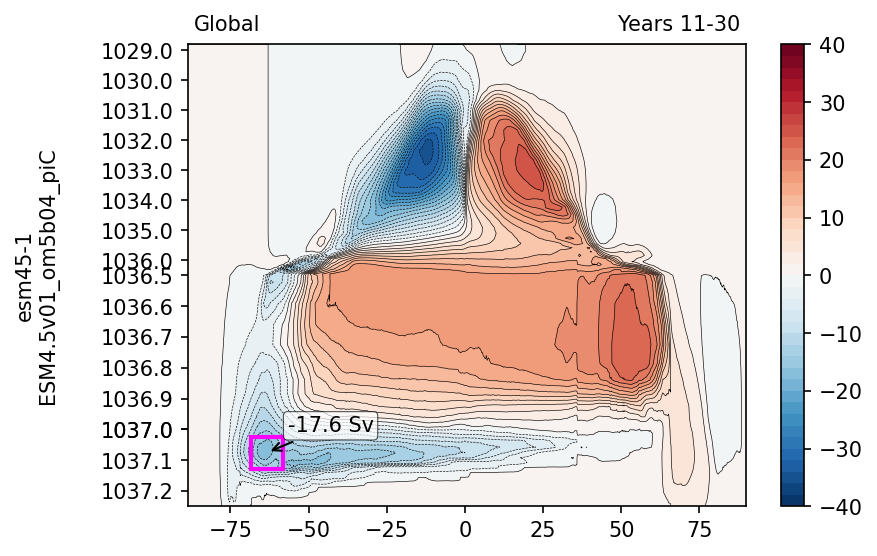

In [21]:
nexp = len(dsets)
fig = plt.figure(figsize=(6, 4 * nexp), dpi=150)

plotcounter = 1
for n, ds in enumerate(dsets):
    ax = plt.subplot(nexp, 1, plotcounter)
    vmo = ds.vmo.where(ds.vmo < 1e14)
    psi = calc_moc_rho(vmo)

    levels = np.arange(-40, 42, 2)

    cb = ax.contourf(psi.yq, psi.rho2_i, psi, levels=levels, cmap="RdBu_r")
    cs = ax.contour(psi.yq, psi.rho2_i, psi, levels=levels, colors="k", linewidths=0.3)

    y = psi.yq
    r = psi.rho2_i
    Y, R = np.meshgrid(y, r)
    mask = (Y >= -75) & (Y <= -50) & (R >= 1036.8) & (R <= 1037.4)
    _psi = psi.values
    min_psi = np.min(_psi[mask])
    min_index = np.unravel_index(np.argmin(_psi[mask]), _psi[mask].shape)
    min_y = Y[mask][min_index]
    min_r = R[mask][min_index]

    square_size = 10
    ax.plot(
        min_y,
        min_r,
        marker="s",
        color="magenta",
        markersize=square_size + 5,
        markeredgewidth=2,
        markeredgecolor="magenta",
        markerfacecolor="none",
    )
    ax.annotate(
        f"{min_psi:.1f} Sv",
        xy=(min_y, min_r),
        xytext=(10, 10),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black"),
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.2",
            linewidth=0.5,
            alpha=0.7,
        ),
    )

    ax.set_yscale("splitscale", zval=[1037.25, 1036.5, 1028.8])
    plt.colorbar(cb)
    
    if "date_range" in ds.attrs.keys():
        date_range = ds.attrs["date_range"]
    else:
        date_range = ""
    ax.text(.99,1.03,date_range,ha="right", transform=ax.transAxes)
    ax.text(.01,1.03,f"Global",ha="left", transform=ax.transAxes)

    ax.set_ylabel(config["dora_id"].split(",")[n]+"\n"+experiments[n]["expName"], labelpad=20)
    
    plotcounter += 1

### Establish a Dictionary to Store Scalar Metrics

stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
    "starttime": str(starttime.values),
    "endtime": str(endtime.values),
}
stats_dict["results"] = {}
stats_dict

### Write Stats to a File

if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('oisst_stats.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)